# 🛒 Online Retail EDA & Prep Notebook

## 1. Introduction

- **One-line project summary**  
  This notebook cleans and enriches the UCI Online Retail dataset to produce a reliable, analytics-ready transactions table for downstream dashboards and customer analysis.

- **Business context**  
  A mid-sized UK giftware e-commerce store needs actionable insights to optimize revenue and customer engagement.  
  **Key questions:**  
  1. How have total sales evolved month-over-month?  
  2. Which products contribute most to revenue?  
  3. Which markets (countries) drive the bulk of transactions?  
  4. How can we prepare the data for customer segmentation and visualization?


## 2. Objectives

1. **Clean & Standardize Data**  
   Remove invalid or cancelled transactions, handle missing values, and compute a `TotalPrice` field to ensure a single, accurate source of truth.

2. **Generate Core Sales Metrics**  
   Create time-series and aggregate views (monthly revenue, top products, country breakdown) to reveal high-level performance trends.

3. **Prepare for Customer Analysis**  
   Structure the cleaned dataset for easy downstream use—export `cleaned_retail.csv` with all required fields for segmentation and BI tools.

4. **Document Key Insights**  
   Summarize 3–5 actionable findings (e.g., “Top 5 products account for 60 % of revenue”) to guide business decisions.

5. **Ensure Reproducibility**  
   Save all outputs programmatically and include clear instructions so any reviewer can rerun this notebook end-to-end.  


## 3. Dataset Overview

- **Source & License**  
  UCI Machine Learning Repository — “Online Retail” dataset (https://archive.ics.uci.edu/dataset/352/online+retail). Licensed under the UCI data use terms.

- **Dataset snapshot**  
  - **Rows:** 541,909  
  - **Columns:** 8  

- **Data dictionary**  

  | Column       | Type       | Description                                                    |
  |--------------|------------|----------------------------------------------------------------|
  | `InvoiceNo`  | string     | Unique transaction identifier; 'C' prefix indicates cancellation |
  | `StockCode`  | string     | Unique product code                                           |
  | `Description`| string     | Product name/description                                      |
  | `Quantity`   | integer    | Number of items purchased                                     |
  | `InvoiceDate`| datetime   | Transaction timestamp                                         |
  | `UnitPrice`  | float      | Price per item (GBP)                                          |
  | `CustomerID` | integer    | Unique customer identifier                                    |
  | `Country`    | string     | Customer’s country of residence                               |

> *Note:* We will drop cancellations and missing `CustomerID` rows in the cleaning step.

## 4. Environment & Setup

Before diving into the analysis, we’ll configure the Python environment and define the key project paths.

In [26]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 2. Display settings
pd.set_option('display.max_columns', None)
%matplotlib inline

# 3. Define project paths
RAW_DATA_PATH      = "../data/raw/Online retail.xlsx"
PROCESSED_DATA_DIR = "../data/processed/"

> **Notes:**  
> - We use `pandas` and `numpy` for data manipulation and `matplotlib` for quick plotting.  
> - The folder variables ensure all file operations are reproducible and easy to update.  
> - Running this cell without errors confirms you have the right dependencies installed.


## 5. Data Ingestion

In this section, we load the raw Excel file into a DataFrame and perform initial sanity checks.

In [27]:
# Load raw data
df_raw = pd.read_excel(RAW_DATA_PATH)

# Quick sanity checks
print("Rows, Columns:", df_raw.shape)
display(df_raw.head())

Rows, Columns: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


> **Notes:**  
> - We read directly from the `.xlsx` to ensure the source data is untouched.  
> - The shape check confirms the expected ~542K rows and 8 columns.  
> - Displaying the first few records helps verify column names and detect any obvious issues (e.g., incorrect types).


## 6. Data Cleaning & Enrichment

This section applies all necessary cleaning steps to prepare the data for analysis:

1. **Drop canceled transactions** where `InvoiceNo` starts with “C”.  
2. **Remove rows** missing `CustomerID`.  
3. **Convert** `InvoiceDate` to datetime if not already.  
4. **Compute** a `TotalPrice` column = `Quantity * UnitPrice`.  
5. **Filter** out non-positive `Quantity` or `UnitPrice` values.  
6. **Save** the cleaned DataFrame as `cleaned_retail.csv` for downstream use.


In [ ]:
# 1. Remove cancellations
df = df_raw[~df_raw['InvoiceNo'].astype(str).str.startswith('C')]

# 2. Drop missing customers
df = df.dropna(subset=['CustomerID'])

# 3. Ensure datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 4. Calculate total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# 5. Filter out invalid quantities/prices
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# 6. Export cleaned data
df.to_csv(PROCESSED_DATA_DIR + "cleaned_retail.csv", index=False)

print(f"Cleaned dataset: {df.shape[0]} rows, {df.shape[1]} columns")


Transacciones canceladas: 9288
Cleaned dataset: 397884 rows, 9 columns


> **Notes:**  
> - Cancellations are identified by the “C” prefix on `InvoiceNo` and must be removed to avoid negative sales.  
> - Missing `CustomerID` rows cannot be segmented later, so we drop them.  
> - The `TotalPrice` field is crucial for all revenue analyses.  
> - Filtering non-positive values guards against data-entry errors or returns.  
> - The cleaned CSV becomes the single source-of-truth for subsequent EDA and segmentation.


## 7. Exploratory Data Analysis

In this section we answer our key sales questions with visualizations.

### 7.1 Monthly Revenue Trend

📈 Peak revenue month: 2011-11 → £1,161,817.38
➡️ This is 69.5% above the average monthly revenue of £685,492.92


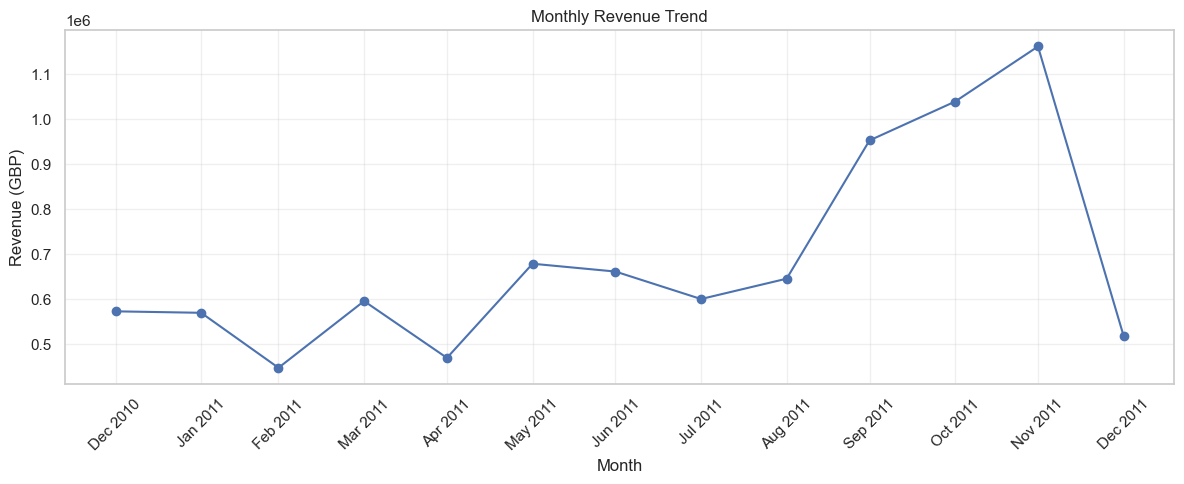

In [38]:
# 1. Aggregate revenue by month
monthly = (
    df
    .set_index('InvoiceDate')
    .resample('ME')['TotalPrice']
    .sum()
    .reset_index()
)

# 2. Calculate average monthly revenue
avg_revenue = monthly['TotalPrice'].mean()

# 3. Find the month with highest revenue
peak_idx = monthly['TotalPrice'].idxmax()
peak_row = monthly.loc[peak_idx]
peak_month = peak_row['InvoiceDate'].strftime('%Y-%m')
peak_value = peak_row['TotalPrice']

# 4. Compute percentage above average
peak_pct_above = (peak_value - avg_revenue) / avg_revenue * 100

# 5. Display results
print(f"📈 Peak revenue month: {peak_month} → £{peak_value:,.2f}")
print(f"➡️ This is {peak_pct_above:.1f}% above the average monthly revenue of £{avg_revenue:,.2f}")

# 6. Plot full monthly series with all months labeled
plt.figure(figsize=(12,5))
plt.plot(monthly['InvoiceDate'], monthly['TotalPrice'], marker='o')
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (GBP)')
plt.xticks(monthly['InvoiceDate'], monthly['InvoiceDate'].dt.strftime('%b %Y'), rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

> **Notes:**  
> - Shows seasonality & growth/shrinkage over time.  
> - Look for peaks (e.g., holiday spikes) or downward trends that flag business issues.

### 7.2 Top-10 Products by Revenue

Top 10 Products by Revenue:
                       Description    Revenue PctShare
       PAPER CRAFT , LITTLE BIRDIE 168,469.60     1.9%
          REGENCY CAKESTAND 3 TIER 142,592.95     1.6%
WHITE HANGING HEART T-LIGHT HOLDER 100,448.15     1.1%
           JUMBO BAG RED RETROSPOT  85,220.78     1.0%
    MEDIUM CERAMIC TOP STORAGE JAR  81,416.73     0.9%
                           POSTAGE  77,803.96     0.9%
                     PARTY BUNTING  68,844.33     0.8%
     ASSORTED COLOUR BIRD ORNAMENT  56,580.34     0.6%
                            Manual  53,779.93     0.6%
                RABBIT NIGHT LIGHT  51,346.20     0.6%


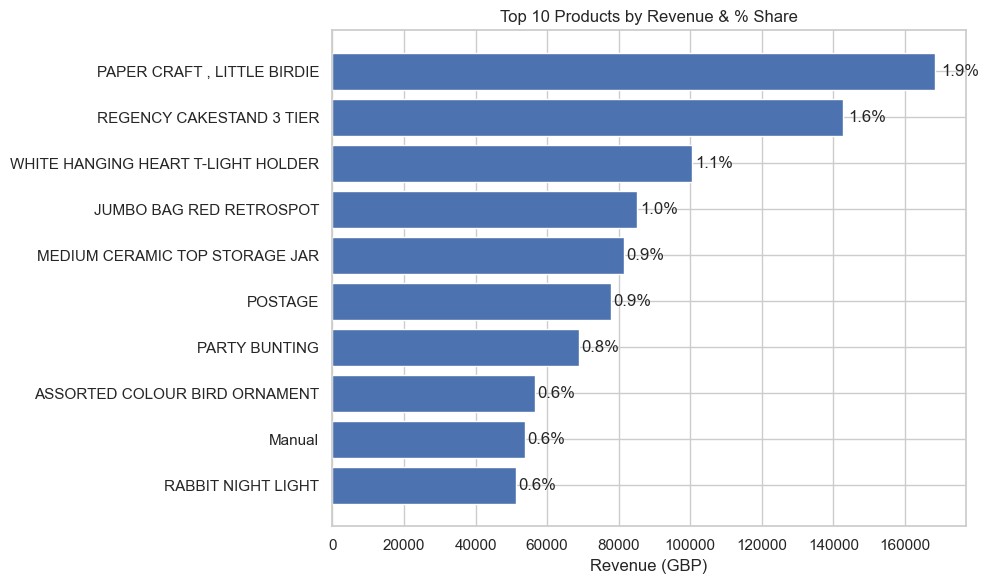

In [39]:
# 1. Sum revenue per product
top_products = (
    df
    .groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='Revenue')
)

# 2. Compute percentage of total revenue
total_revenue = df['TotalPrice'].sum()
top_products['PctShare'] = (top_products['Revenue'] / total_revenue) * 100

# 3. Print the list of products with revenue and percentage
print("Top 10 Products by Revenue:")
print(top_products.to_string(index=False, 
      formatters={'Revenue': '{:,.2f}'.format, 'PctShare': '{:.1f}%'.format}))

# 4. Plot horizontal bar chart with percentage labels
plt.figure(figsize=(10,6))
bars = plt.barh(top_products['Description'][::-1], top_products['Revenue'][::-1])
plt.title('Top 10 Products by Revenue & % Share')
plt.xlabel('Revenue (GBP)')
plt.xticks(rotation=0)

# Annotate bars with percentage share
for bar, pct in zip(bars, top_products['PctShare'][::-1]):
    width = bar.get_width()
    plt.text(width * 1.01, bar.get_y() + bar.get_height()/2,
             f'{pct:.1f}%', va='center')

plt.tight_layout()
plt.show()

> **Notes:**  
> - Identifies best-selling SKUs.  
> - Useful for inventory prioritization or promotional strategies.

### 7.3 Revenue by Country

Top 5 Countries by Revenue and % Share:
       Country      Revenue PctShare
United Kingdom 7,308,391.55    82.0%
   Netherlands   285,446.34     3.2%
          EIRE   265,545.90     3.0%
       Germany   228,867.14     2.6%
        France   209,024.05     2.3%


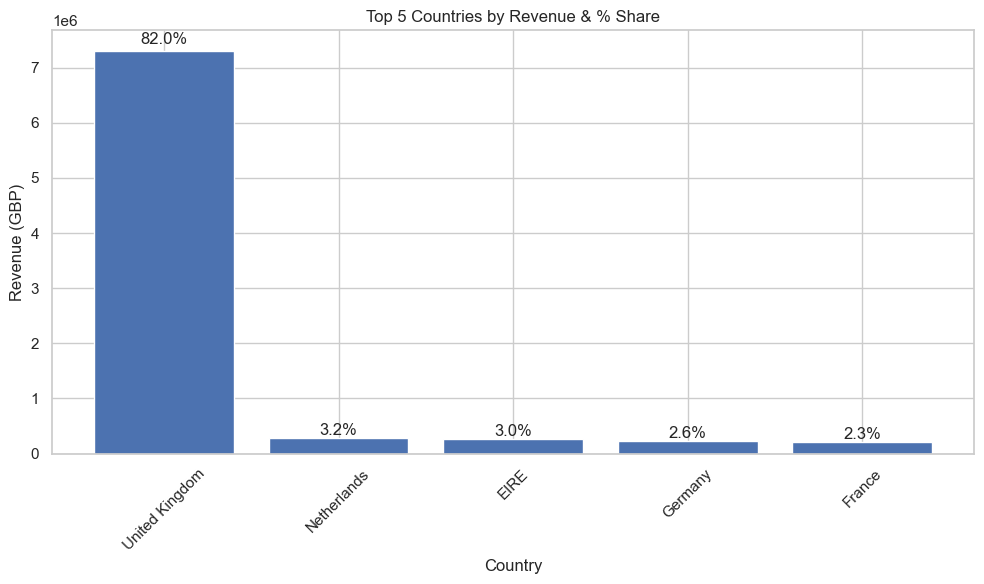

In [40]:
# Sum revenue per country and select top 5
country_sales = (
    df
    .groupby('Country')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .reset_index(name='Revenue')
)

# Compute percentage of total revenue
total_revenue = df['TotalPrice'].sum()
country_sales['PctShare'] = (country_sales['Revenue'] / total_revenue) * 100

# Print the top 5 countries with revenue and percentage share
print("Top 5 Countries by Revenue and % Share:")
print(country_sales.to_string(index=False,
      formatters={'Revenue': '{:,.2f}'.format, 'PctShare': '{:.1f}%'.format}))

# Plot bar chart with percentage annotations
plt.figure(figsize=(10,6))
bars = plt.bar(country_sales['Country'], country_sales['Revenue'])
plt.title('Top 5 Countries by Revenue & % Share')
plt.xlabel('Country')
plt.ylabel('Revenue (GBP)')
plt.xticks(rotation=45)

# Annotate each bar with its percentage share
for bar, pct in zip(bars, country_sales['PctShare']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height * 1.01,
             f'{pct:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


> **Notes:**  
> - Highlights key markets.  
> - Can guide where to focus marketing or localization efforts.

### 7.4 Pareto 80/20 Check

811 products account for 80% of revenue


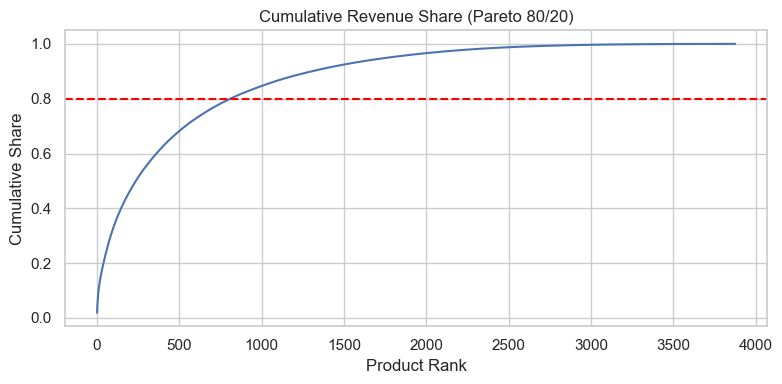

In [32]:
# cumulative revenue share
prod_rev = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False)
cum_share = prod_rev.cumsum() / prod_rev.sum()

# find cutoff
n_80 = (cum_share >= 0.8).idxmax()
count_80 = cum_share.index.get_loc(n_80) + 1

print(f"{count_80} products account for 80% of revenue")

# optional plot of cumulative share
plt.figure(figsize=(8,4))
plt.plot(cum_share.values)
plt.axhline(0.8, color='red', linestyle='--')
plt.title('Cumulative Revenue Share (Pareto 80/20)')
plt.xlabel('Product Rank')
plt.ylabel('Cumulative Share')
plt.tight_layout()
plt.show()


> **Notes:**  
> - Shows how concentrated revenue is among top SKUs.  
> - If 80% comes from few products, focus merchandising on that core list.

## 8. Key Insights

- **Peak Revenue:** November 2011 generated **£1,161,817.38**, which is **69.5 % above** the average monthly revenue of £685,492.92.  
- **Top-Selling SKU Impact:** The top product (“PAPER CRAFT, LITTLE BIRDIE”) contributed **£168,469.60** (1.9 % of total revenue), and the top 10 SKUs combined account for only **~9 %** of all sales—highlighting a long tail of lower-volume items.  
- **Market Dependence:** The United Kingdom drives **82.0 %** of revenue; the next four countries (Netherlands, EIRE, Germany, France) together contribute just **11.1 %**, indicating a heavy reliance on the UK market.  
- **Product Concentration:** **811 products** (out of ~4,000 unique SKUs) generate **80 %** of total revenue, suggesting that focusing on this core catalog could maximize ROI.  
- **Data Cleaning Impact:** **9,288** cancelled transactions (≈1.7 % of all rows) were removed to ensure accurate sales figures.  


## 9. Export Processed Data

In this section we write out the cleaned transactions table for use in downstream analysis and visualization.


In [43]:
# 1. Ensure the processed data directory exists
import os
os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)

# 2. Export the cleaned retail dataset
df.to_csv(PROCESSED_DATA_DIR + "cleaned_retail.csv", index=False)

# 3. Confirm export
rows, cols = df.shape
print(f"✅ Exported cleaned_retail.csv with {rows:,} rows and {cols} columns to `{PROCESSED_DATA_DIR}`")

✅ Exported cleaned_retail.csv with 397,884 rows and 9 columns to `../data/processed/`


> **Notes:**  
> - This single `cleaned_retail.csv` file is now the canonical fact table for all dashboards and scripts.  
> - Any further analysis or notebook (e.g., RFM segmentation) should read from this file to ensure consistency.  

## 10. Reproducibility & Next Steps

- **Reproduce this analysis**  
  1. Clone the repo and navigate to the project root.  
  2. Install dependencies:  
     ```bash
     pip install -r requirements.txt
     ```  
  3. (Optional) Launch a Docker container:  
     ```bash
     docker build -t online-retail .
     docker run --rm -v $(pwd)/data:/app/data online-retail
     ```  
  4. Run this notebook start-to-finish; it will produce `/data/processed/cleaned_retail.csv`.

- **What’s next?**  
  1. Open **`02_rfm_segmentation.ipynb`** to perform RFM customer segmentation.  
  2. Use the exported CSVs in your Power BI dashboard (or Streamlit app) to visualize and explore.  
  3. Prepare **`03_dashboard_logic.ipynb`** (optional) to document any additional data transformations for your dashboard.  

> Keeping this notebook and its outputs immutable ensures that all downstream reports and analyses remain consistent and traceable.  
